# 03 - Augmentation Visualization

Visualize augmentation pipeline results:
- ZJitter
- BasicAugs (HorizontalFlip, VerticalFlip, RandomRotate90)
- PipMix
- Normalize

In [13]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from src.data.dataset import VesuviusLMDBDataset
from src.data.transforms import (
    ZJitter, BasicAugs, PipMix, Normalize,
    AugmentationPipeline, get_train_transforms, get_val_transforms
)

# Paths
LMDB_PATH = Path('../dataset/processed/train.lmdb')
STATS_PATH = Path('../dataset/stats/mean_std.npy')

print(f"LMDB exists: {LMDB_PATH.exists()}")
print(f"Stats exists: {STATS_PATH.exists()}")

LMDB exists: True
Stats exists: True


## 1. Load Dataset

In [14]:
# Load dataset without transforms
dataset = VesuviusLMDBDataset(
    lmdb_path=LMDB_PATH,
    transform=None,
    split='train',
    return_metadata=True
)

print(f"Dataset size: {len(dataset)}")

Dataset size: 616


In [15]:
# Get a sample
sample = dataset[0]
image = sample['image']
label = sample['label']

print(f"Image shape: {image.shape}")
print(f"Label shape: {label.shape}")
print(f"Image dtype: {image.dtype}")
print(f"Image range: [{image.min():.2f}, {image.max():.2f}]")

Image shape: torch.Size([320, 320, 320])
Label shape: torch.Size([320, 320, 320])
Image dtype: torch.float32
Image range: [0.00, 255.00]


## 2. Visualization Helper

In [16]:
def visualize_volume(
    image, 
    label=None, 
    title="Volume", 
    slice_indices=None,
    figsize=(15, 5)
):
    """
    Visualize 3D volume at different Z slices.
    
    Args:
        image: (D, H, W) tensor or numpy array
        label: Optional (D, H, W) tensor or numpy array
        title: Plot title
        slice_indices: List of Z indices to show, defaults to [D//4, D//2, 3*D//4]
    """
    if hasattr(image, 'numpy'):
        image = image.numpy()
    if label is not None and hasattr(label, 'numpy'):
        label = label.numpy()
    
    D = image.shape[0]
    
    if slice_indices is None:
        slice_indices = [D//4, D//2, 3*D//4]
    
    n_slices = len(slice_indices)
    n_rows = 2 if label is not None else 1
    
    fig, axes = plt.subplots(n_rows, n_slices, figsize=figsize)
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(title, fontsize=14)
    
    for i, z in enumerate(slice_indices):
        # Image
        axes[0, i].imshow(image[z], cmap='gray')
        axes[0, i].set_title(f"Image Z={z}")
        axes[0, i].axis('off')
        
        # Label
        if label is not None:
            axes[1, i].imshow(label[z], cmap='tab10', vmin=0, vmax=2)
            axes[1, i].set_title(f"Label Z={z}")
            axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

## 3. Original Data

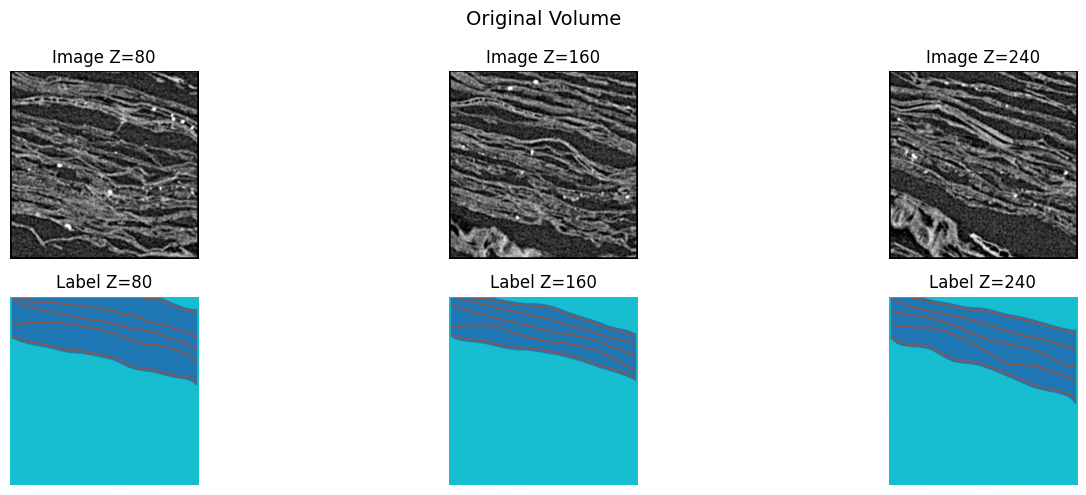

In [17]:
visualize_volume(image, label, title="Original Volume")

## 4. ZJitter Transform

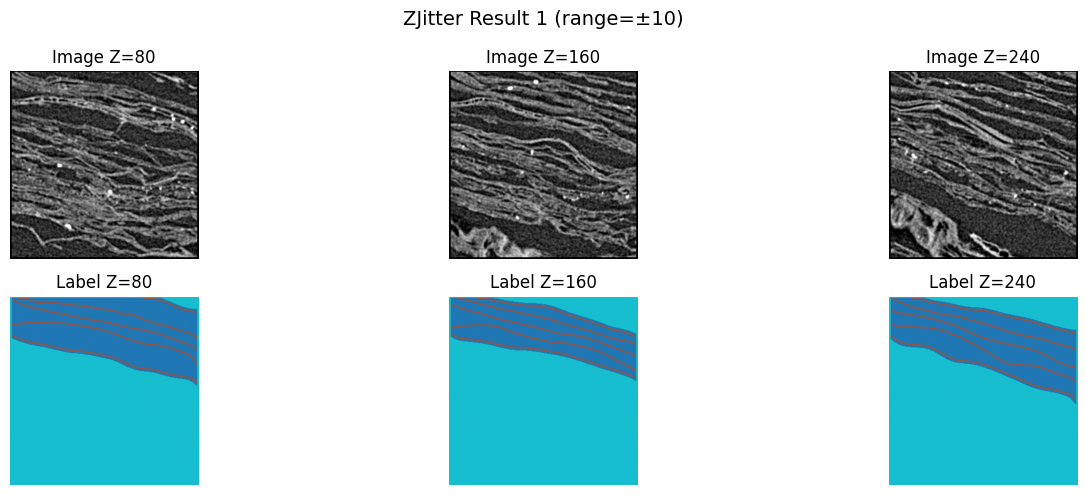

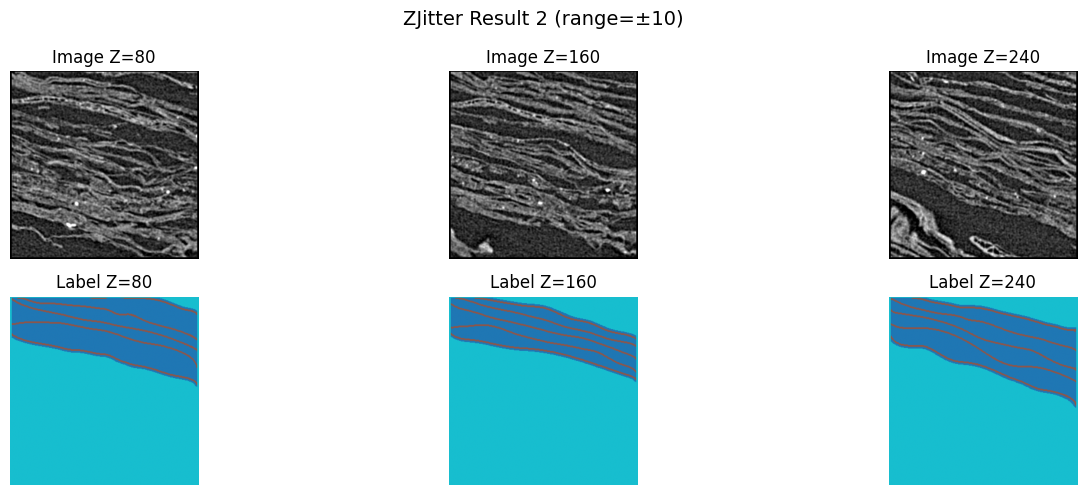

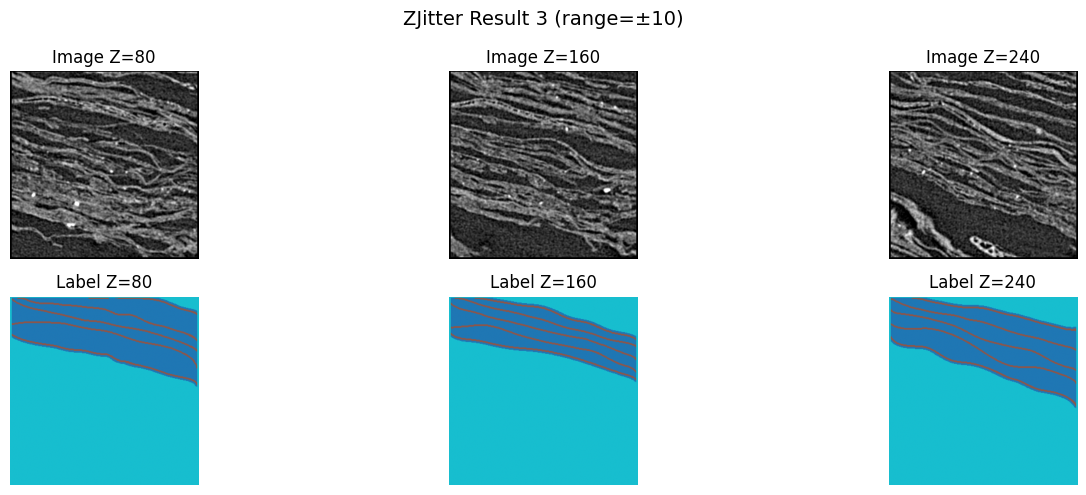

In [18]:
# Apply ZJitter
z_jitter = ZJitter(jitter_range=10)

# Apply multiple times to see different results
for i in range(3):
    jittered_img, jittered_lbl = z_jitter(image.clone(), label.clone())
    visualize_volume(
        jittered_img, jittered_lbl, 
        title=f"ZJitter Result {i+1} (range=±10)"
    )

## 5. BasicAugs Transform

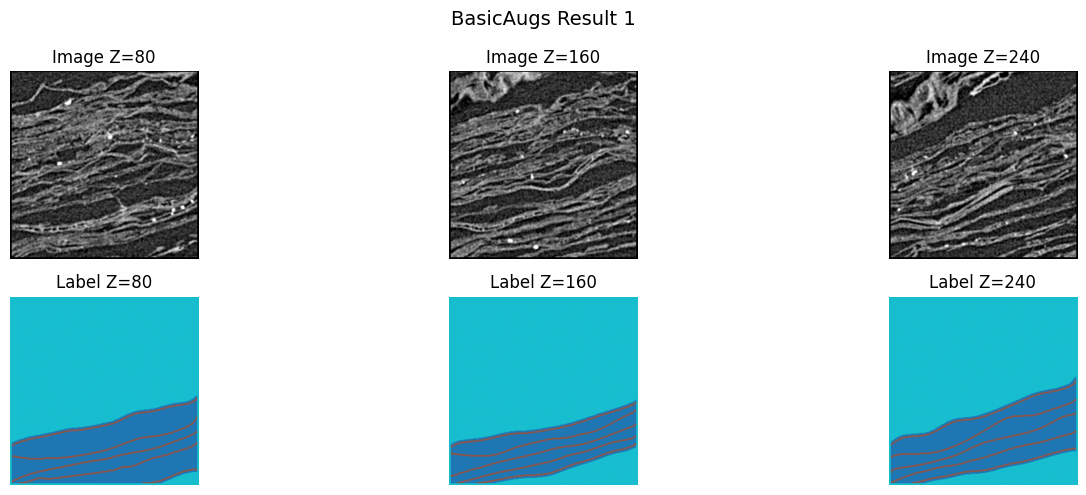

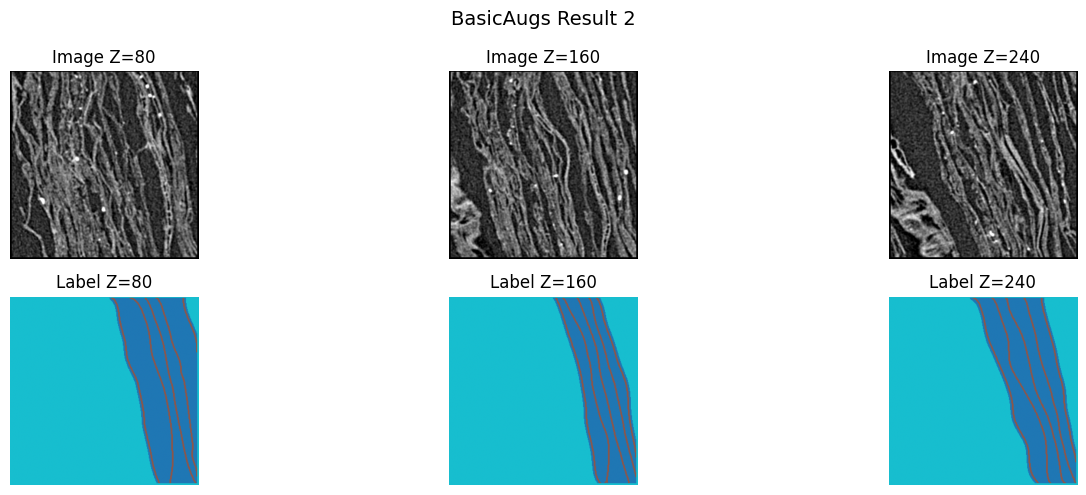

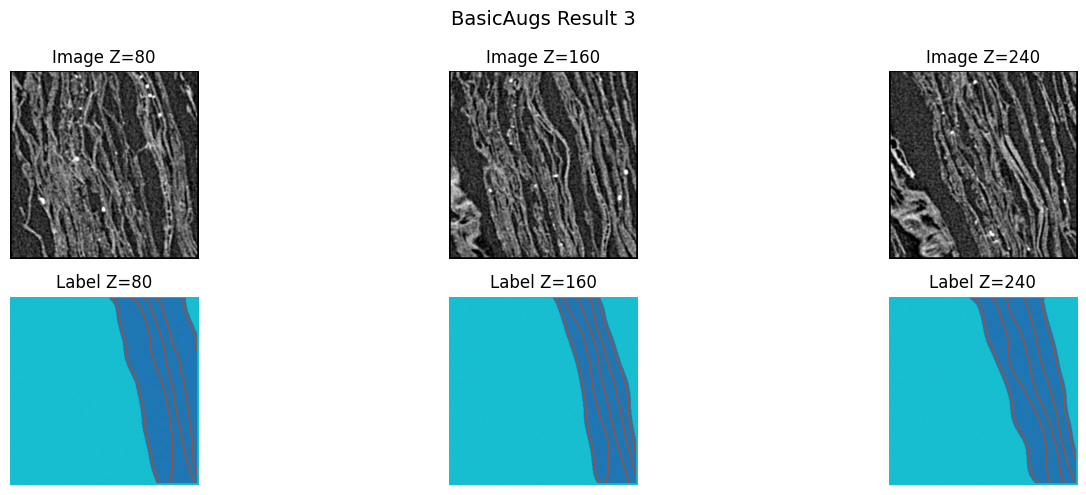

In [19]:
# Apply BasicAugs
basic_augs = BasicAugs(p_hflip=0.5, p_vflip=0.5, p_rot90=0.5)

# Apply multiple times to see different results
for i in range(3):
    aug_img, aug_lbl = basic_augs(image.clone(), label.clone())
    visualize_volume(
        aug_img, aug_lbl, 
        title=f"BasicAugs Result {i+1}"
    )

## 6. PipMix Transform

Sample 1:


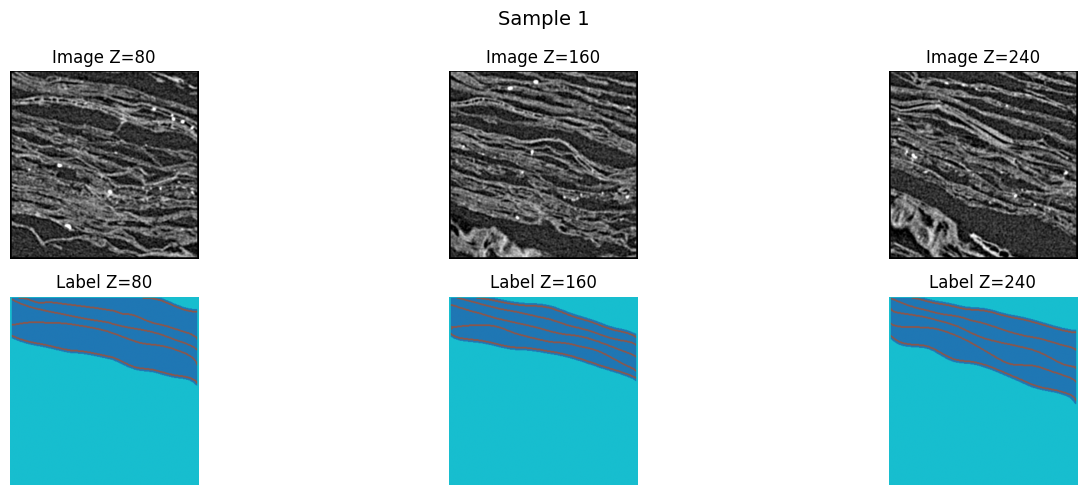

Sample 2:


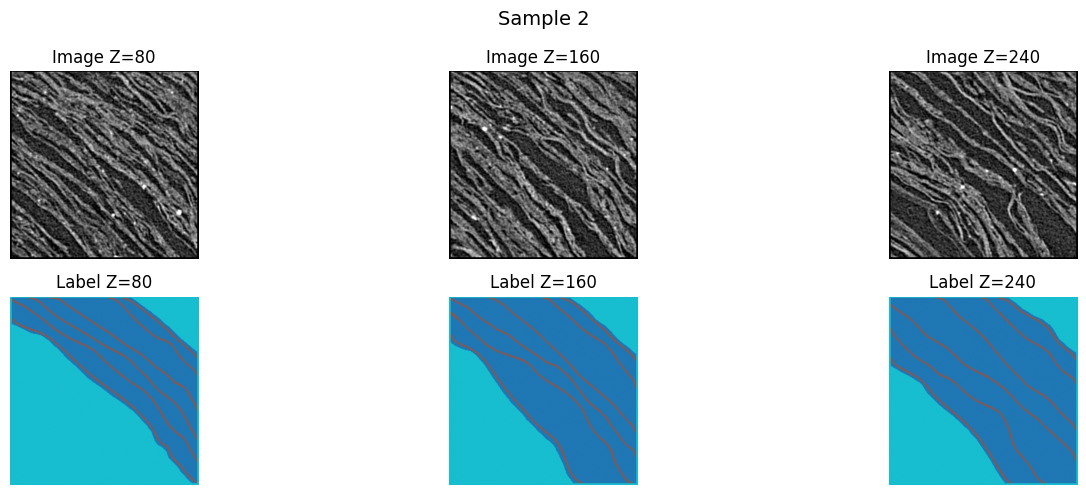

In [20]:
# Get two samples for PipMix
sample1 = dataset[0]
sample2 = dataset[1]

image1, label1 = sample1['image'], sample1['label']
image2, label2 = sample2['image'], sample2['label']

print("Sample 1:")
visualize_volume(image1, label1, title="Sample 1")

print("Sample 2:")
visualize_volume(image2, label2, title="Sample 2")

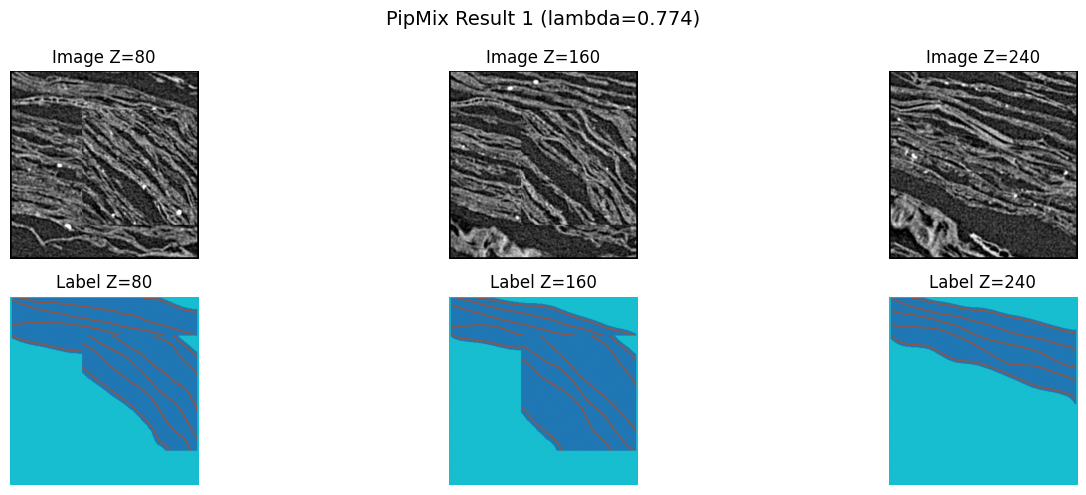

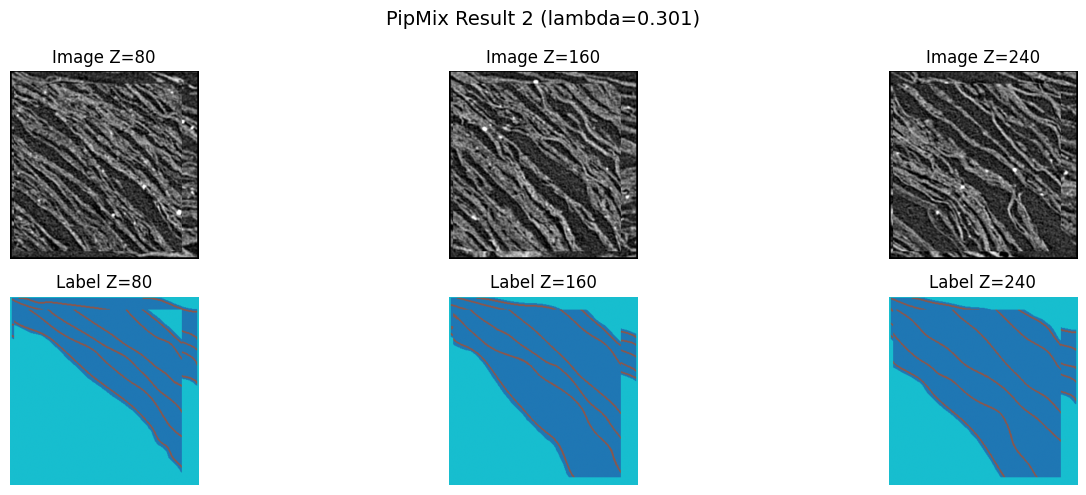

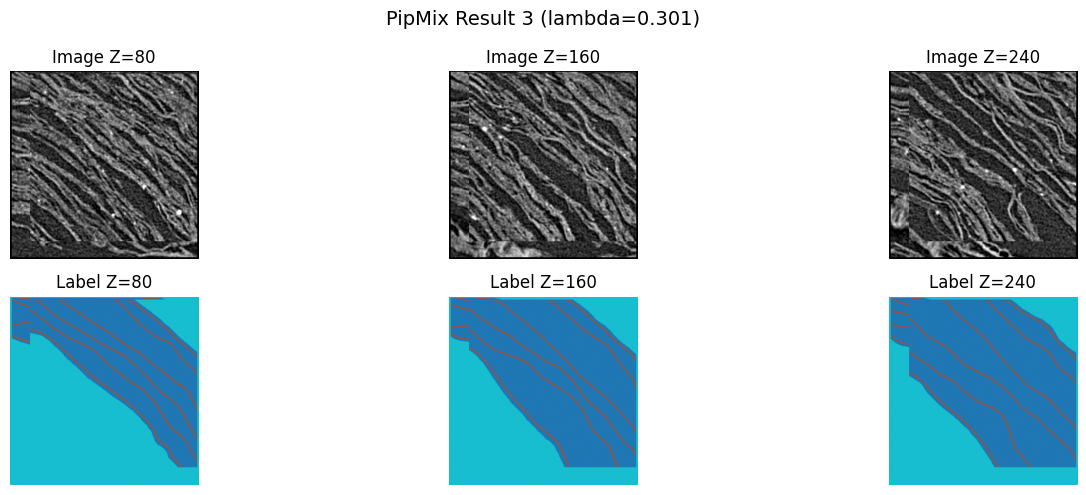

In [21]:
# Apply PipMix
pipmix = PipMix(alpha=1.0, p=1.0)  # p=1.0 to always apply

for i in range(3):
    mixed_img, mixed_lbl, lam = pipmix(
        image1.clone(), label1.clone(),
        image2.clone(), label2.clone()
    )
    visualize_volume(
        mixed_img, mixed_lbl, 
        title=f"PipMix Result {i+1} (lambda={lam:.3f})"
    )

## 7. Normalize Transform

In [22]:
# Check if stats file exists
if STATS_PATH.exists():
    stats = np.load(STATS_PATH, allow_pickle=True).item()
    print(f"Mean: {stats['mean']}")
    print(f"Std: {stats['std']}")
    
    normalize = Normalize(stats_path=STATS_PATH)
else:
    print("Stats file not found, using default values")
    normalize = Normalize(mean=127.5, std=127.5)

# Apply normalization
norm_img, _ = normalize(image.clone(), label.clone())

print(f"\nBefore normalization:")
print(f"  Range: [{image.min():.2f}, {image.max():.2f}]")
print(f"  Mean: {image.float().mean():.2f}")
print(f"  Std: {image.float().std():.2f}")

print(f"\nAfter normalization:")
print(f"  Range: [{norm_img.min():.2f}, {norm_img.max():.2f}]")
print(f"  Mean: {norm_img.mean():.2f}")
print(f"  Std: {norm_img.std():.2f}")

Mean: [70.8973]
Std: [42.479748]

Before normalization:
  Range: [0.00, 255.00]
  Mean: 71.40
  Std: 44.92

After normalization:
  Range: [-1.67, 4.33]
  Mean: 0.01
  Std: 1.06


## 8. Full Pipeline (Train vs Val)

In [23]:
# Training pipeline
train_transform = get_train_transforms(
    stats_path=STATS_PATH if STATS_PATH.exists() else None,
    z_jitter_range=5
)

# Validation pipeline
val_transform = get_val_transforms(
    stats_path=STATS_PATH if STATS_PATH.exists() else None
)

print("Pipelines initialized!")

Pipelines initialized!


=== Original ===


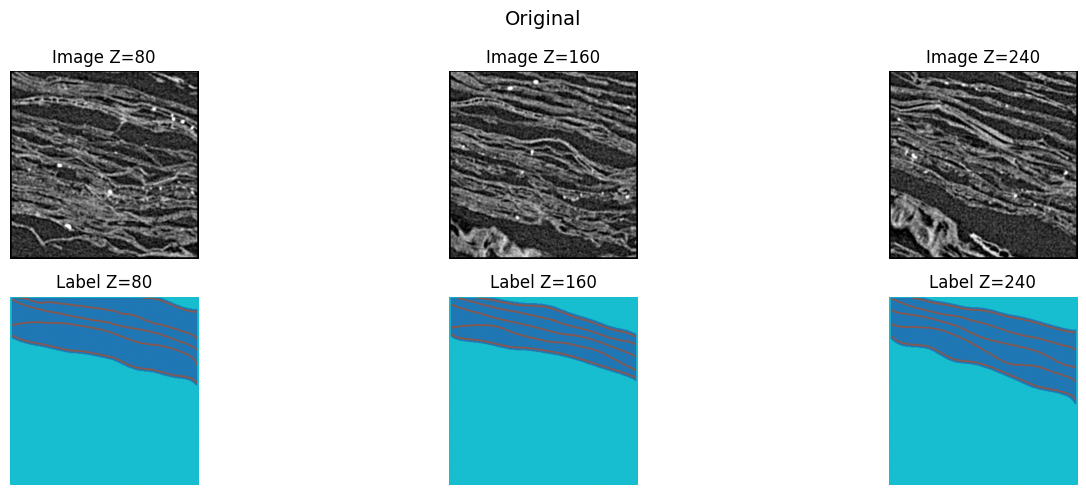


=== Training Transform (with augmentations) ===


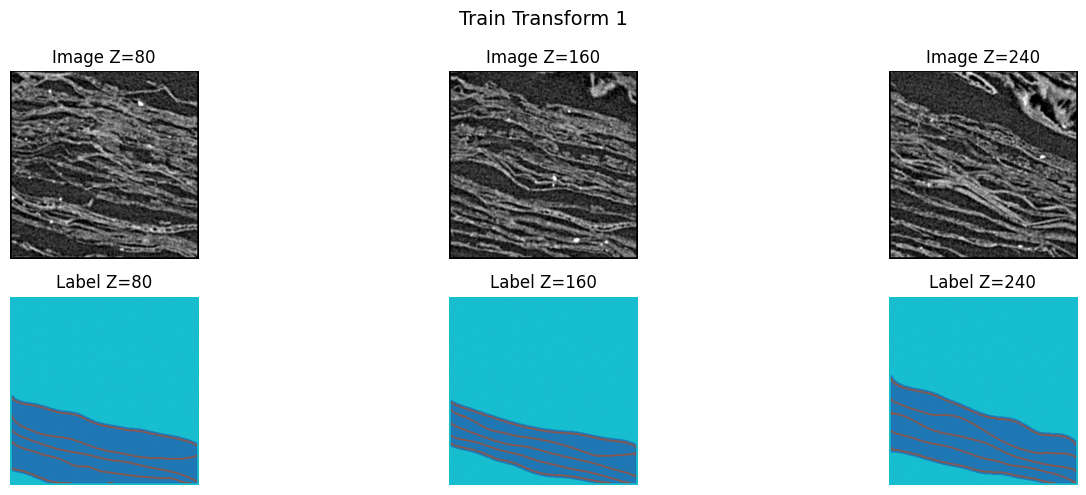

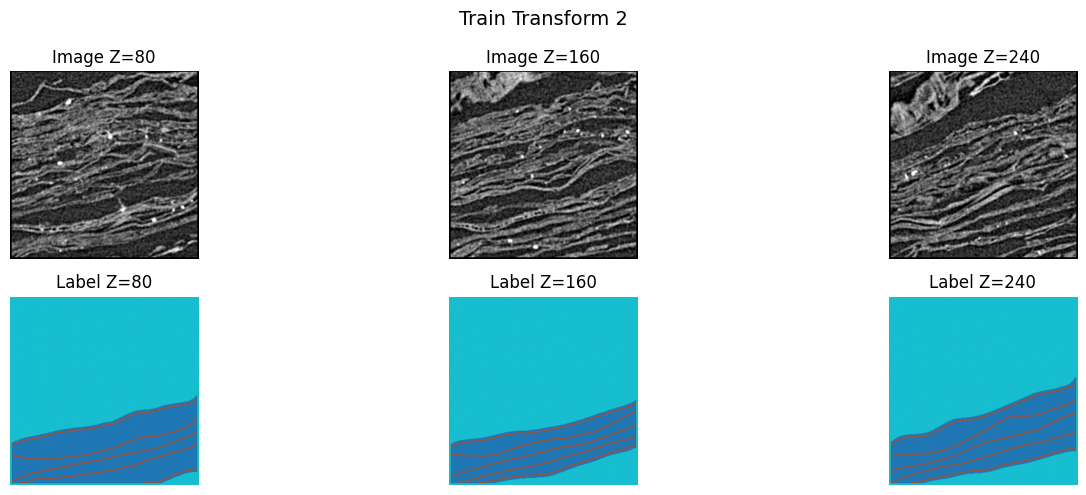

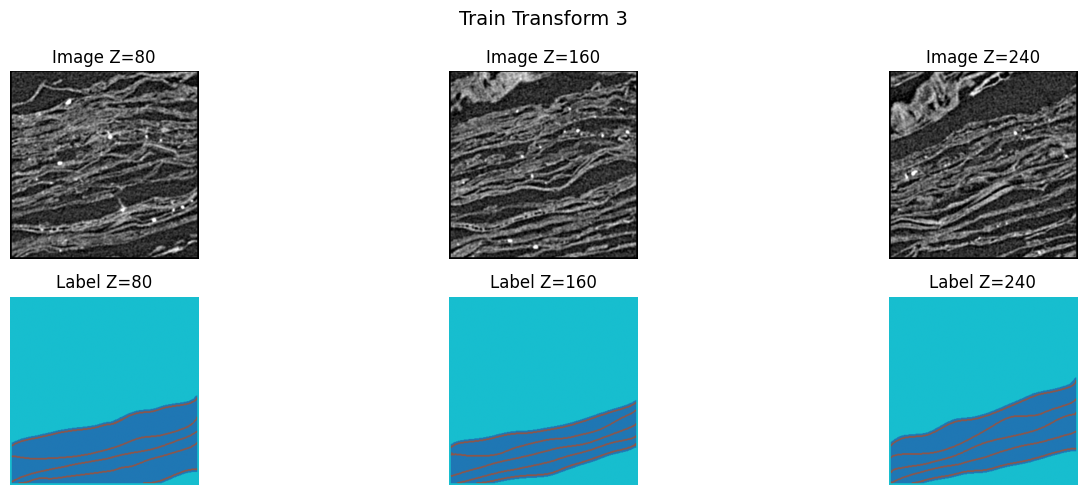


=== Validation Transform (normalize only) ===


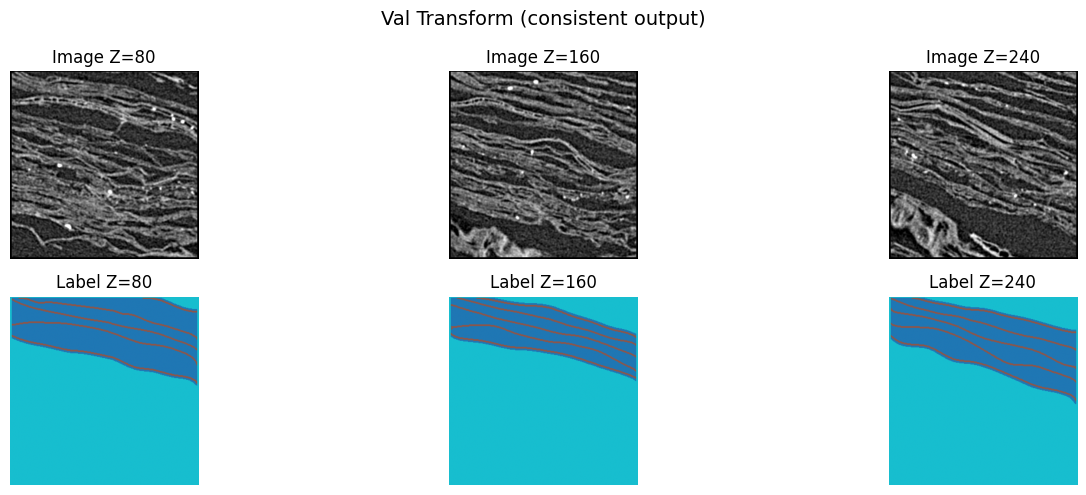

In [24]:
# Compare train vs val transforms
print("=== Original ===")
visualize_volume(image, label, title="Original")

print("\n=== Training Transform (with augmentations) ===")
for i in range(3):
    train_img, train_lbl = train_transform(image.clone(), label.clone())
    visualize_volume(train_img, train_lbl, title=f"Train Transform {i+1}")

print("\n=== Validation Transform (normalize only) ===")
val_img, val_lbl = val_transform(image.clone(), label.clone())
visualize_volume(val_img, val_lbl, title="Val Transform (consistent output)")

## 9. Summary

| Transform | Description | Train | Val |
|-----------|-------------|-------|-----|
| ZJitter | Random Z-axis shift | ✅ | ❌ |
| HorizontalFlip | Flip along X-axis (p=0.5) | ✅ | ❌ |
| VerticalFlip | Flip along Y-axis (p=0.5) | ✅ | ❌ |
| RandomRotate90 | Random 90° rotation (p=0.5) | ✅ | ❌ |
| PipMix | Mix two volumes (batch-level) | ✅ | ❌ |
| Normalize | Mean/std normalization | ✅ | ✅ |